# Features Engineering

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

In [4]:
%matplotlib inline

In [ ]:
train = pd.read_csv('C://Users//Sherry Yang//Documents//Python Scripts//used_car_train_20200313//used_car_train_20200313.csv', sep=' ')
test = pd.read_csv('C://Users//Sherry Yang//Documents//Python Scripts//used_car_testA_20200313//used_car_testA_20200313.csv', sep=' ')

print(train.shape)
print(test.shape)

In [6]:
train.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [7]:
test.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

## Data Cleansning and Transformation

In [8]:
def outliers_proc(data, col_name, scale=3):
        """
        用于清洗异常值，默认用 box_plot（scale=3）进行清洗
        :return:
        """
        def box_plot_outliers(data_ser, box_scale):
            """
            利用箱线图去除异常值
            """
            iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
            val_low = data_ser.quantile(0.25) - iqr
            val_up = data_ser.quantile(0.75) + iqr
            rule_low = (data_ser < val_low)
            rule_up = (data_ser > val_up)
            return (rule_low, rule_up), (val_low, val_up)
        
        data_n = data.copy()
        data_series = data_n[col_name]
        rule, value = box_plot_outliers(data_series, box_scale=scale)
        index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
        print("Delete number is: {}".format(len(index)))
        data_n = data_n.drop(index)
        data_n.reset_index(drop=True, inplace=True)
        print("Now column number is: {}".format(data_n.shape[0]))
        index_low = np.arange(data_series.shape[0])[rule[0]]
        outliers = data_series.iloc[index_low]
        print("Description of data less than the lower bound is:")
        print(pd.Series(outliers).describe())
        index_up = np.arange(data_series.shape[0])[rule[1]]
        outliers = data_series.iloc[index_up]
        print("Description of data larger than the upper bound is:")
        print(pd.Series(outliers).describe())
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 7))
        sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
        sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
        return data_n

### Think about whether we need to delete the outliers or those abnormal values. Sometimes we may not have to do it.

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


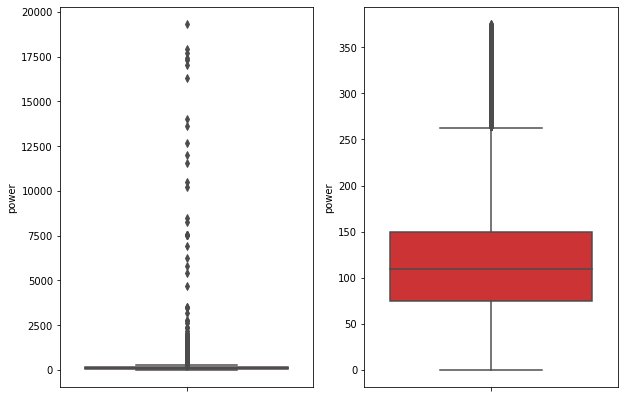

In [9]:
train = outliers_proc(train, 'power', scale=3)

### Data Transformation

In [56]:
train['train']=1
test['train']=0
data = pd.concat([train, test], ignore_index=True, sort=False)

In [57]:
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') -
                        pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [58]:
data['used_time'].isnull().sum()

15072

In [59]:
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])

In [60]:
train_gb = train.groupby("brand")
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

##  Data Binning and bucketing 
### It is a data pre-processing method used to minimize the effects of small observation errors. It has a smoothing effect on the input data and may also reduce the chances of overfitting in case of small datasets

In [61]:
bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [62]:
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [63]:
print(data.shape)
data.columns

(199037, 39)


Index(['SaleID', 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'seller', 'offerType',
       'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'train', 'used_time',
       'city', 'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [41]:
#Data for Decision Tree Model
data.to_csv('data_for_tree.csv', index=0)

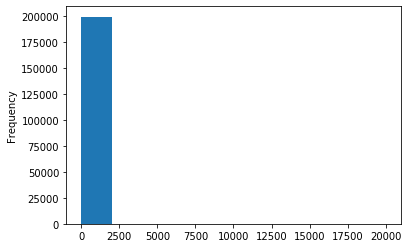

In [64]:
data['power'].plot.hist()

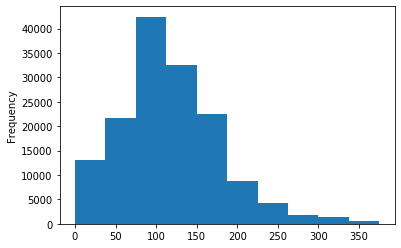

In [43]:
#after cut on the long tail
train['power'].plot.hist()

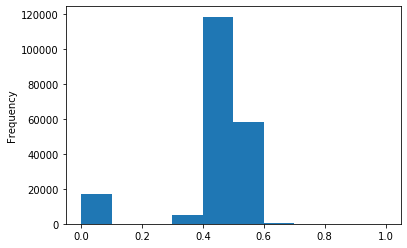

In [65]:
#Take log values to do normalization
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1)
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

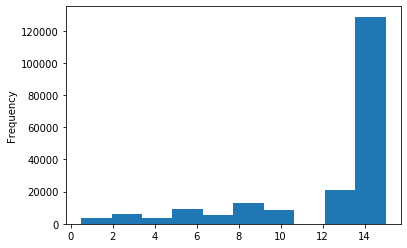

In [66]:
data['kilometer'].plot.hist()

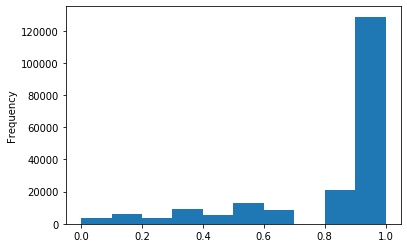

In [67]:
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) /
                        (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

In [69]:
def max_min(x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))
data['brand_amount'] = ((data['brand_amount'] - np.min(data['brand_amount'])) /
(np.max(data['brand_amount']) - np.min(data['brand_amount'])))
data['brand_price_average'] = ((data['brand_price_average'] - np.min(data['brand_price_average'])) /
(np.max(data['brand_price_average']) - np.min(data['brand_price_average'])))
data['brand_price_max'] = ((data['brand_price_max'] - np.min(data['brand_price_max'])) /
(np.max(data['brand_price_max']) - np.min(data['brand_price_max'])))
data['brand_price_median'] = ((data['brand_price_median'] - np.min(data['brand_price_median'])) /
(np.max(data['brand_price_median']) - np.min(data['brand_price_median'])))
data['brand_price_min'] = ((data['brand_price_min'] - np.min(data['brand_price_min'])) /
(np.max(data['brand_price_min']) - np.min(data['brand_price_min'])))
data['brand_price_std'] = ((data['brand_price_std'] - np.min(data['brand_price_std'])) /
(np.max(data['brand_price_std']) - np.min(data['brand_price_std'])))
data['brand_price_sum'] = ((data['brand_price_sum'] - np.min(data['brand_price_sum'])) /
(np.max(data['brand_price_sum']) - np.min(data['brand_price_sum'])))    

In [ ]:
## Take dummy values 

In [71]:
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType','gearbox', 'notRepairedDamage', 'power_bin'])

In [72]:
print(data.shape)
data.columns

(199037, 370)


Index(['SaleID', 'name', 'power', 'kilometer', 'seller', 'offerType', 'price',
       'v_0', 'v_1', 'v_2',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=370)

In [73]:
#data for linear regression
data.to_csv('data_for_lr.csv', index=0)

## Features Selection

In [74]:
#correlation analysis
print(data['power'].corr(data['price'], method='spearman'))
print(data['kilometer'].corr(data['price'], method='spearman'))
print(data['brand_amount'].corr(data['price'], method='spearman'))
print(data['brand_price_average'].corr(data['price'], method='spearman'))
print(data['brand_price_max'].corr(data['price'], method='spearman'))
print(data['brand_price_median'].corr(data['price'], method='spearman'))

0.5728285196051496
-0.4082569701616764
0.058156610025581514
0.3834909576057687
0.259066833880992
0.38691042393409447


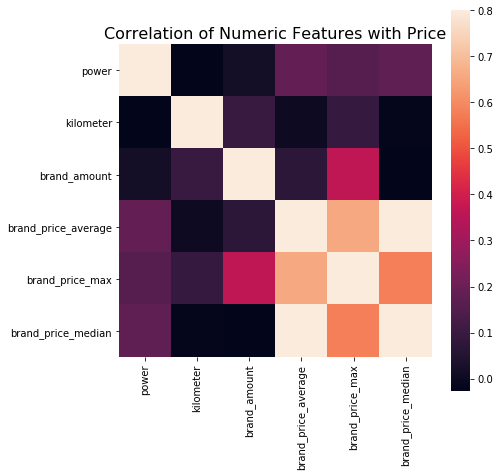

In [75]:
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average',
'brand_price_max', 'brand_price_median']]
correlation = data_numeric.corr()
f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True, vmax=0.8)